In [1]:
#load python packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# data can be found here: https://www.kaggle.com/uciml/adult-census-income
path = os.getcwd()
file_name = 'adult.csv'
path += "/" + file_name

In [3]:
df = pd.read_csv(path, index_col=False)

In [4]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
#fix both 'sex' and 'income' columns to be boolean, and rename the columns so their meaning is clear
#Dropping capital gain, capital loss, and final weight (fnlwgt) since I won't be using them
df.income.replace({'<=50K':0, '>50K':1}, inplace=True)
df.sex.replace({'Female':0, 'Male':1}, inplace=True)
df.rename(columns={'sex':'sex_male', 'income':'income_over_50K'}, inplace=True)
df.drop(['capital.gain','capital.loss','fnlwgt'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   education        32561 non-null  object
 3   education.num    32561 non-null  int64 
 4   marital.status   32561 non-null  object
 5   occupation       32561 non-null  object
 6   relationship     32561 non-null  object
 7   race             32561 non-null  object
 8   sex_male         32561 non-null  int64 
 9   hours.per.week   32561 non-null  int64 
 10  native.country   32561 non-null  object
 11  income_over_50K  32561 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [7]:
#What do the education numbers represent?
education_dict = dict(zip(df['education.num'].value_counts().index, df['education'].value_counts().index))
inverse_education_dict = {v: k for k, v in education_dict.items()}
for key in sorted(education_dict):
    print(key, education_dict[key])

1 Preschool
2 1st-4th
3 5th-6th
4 7th-8th
5 9th
6 10th
7 11th
8 12th
9 HS-grad
10 Some-college
11 Assoc-voc
12 Assoc-acdm
13 Bachelors
14 Masters
15 Prof-school
16 Doctorate


In [8]:
df.nunique()

age                73
workclass           9
education          16
education.num      16
marital.status      7
occupation         15
relationship        6
race                5
sex_male            2
hours.per.week     94
native.country     42
income_over_50K     2
dtype: int64

<AxesSubplot:>

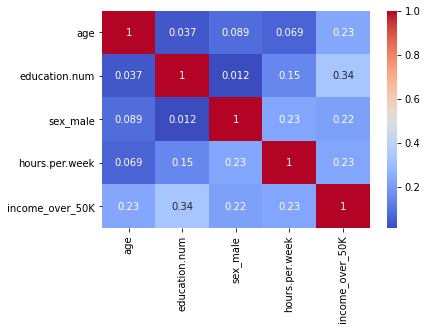

In [9]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

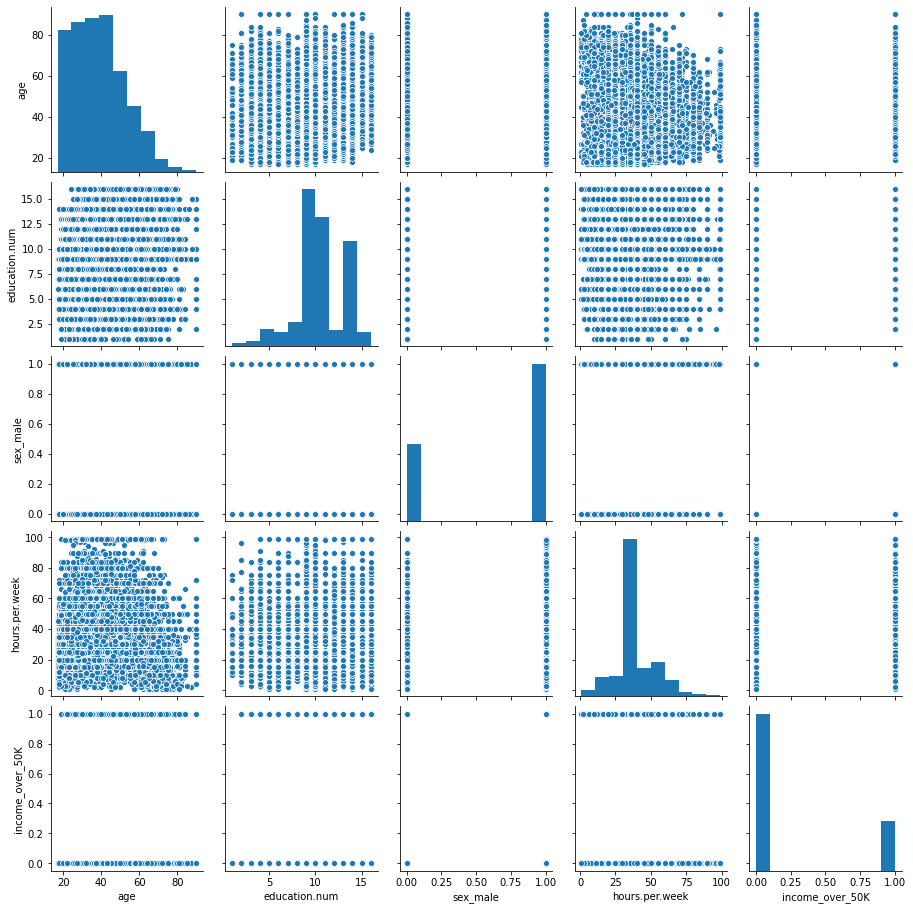

In [10]:
sns.pairplot(df)

<AxesSubplot:>

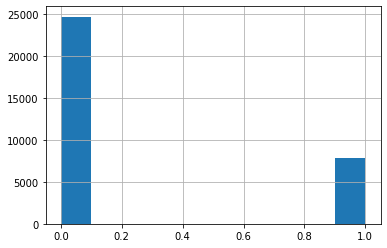

In [11]:
df.income_over_50K.hist()

<AxesSubplot:>

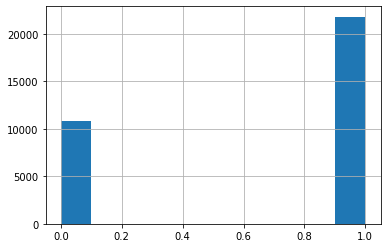

In [12]:
df.sex_male.hist()

<AxesSubplot:>

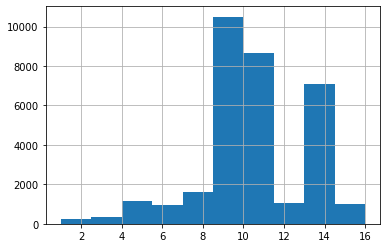

In [13]:
df['education.num'].hist()

Text(0.5, 1.0, 'Breakdown of Population by Race')

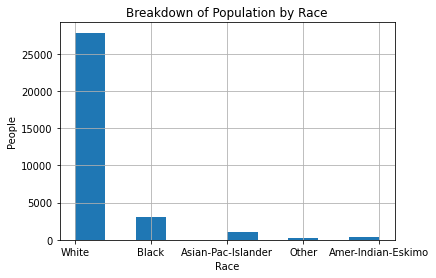

In [31]:
df.race.hist()
plt.xlabel('Race')
plt.ylabel('People')
plt.title('Breakdown of Population by Race')

<AxesSubplot:xlabel='education'>

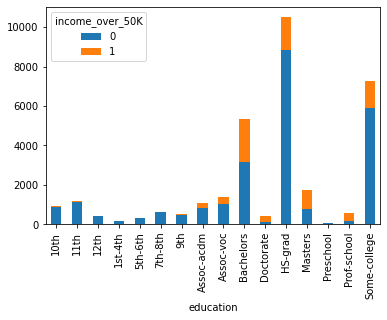

In [15]:
df[['education','income_over_50K']].groupby(['education', 'income_over_50K']).size().unstack().plot(kind='bar', stacked=True)


Text(0.5, 1.0, 'Income over/under 50K by Education')

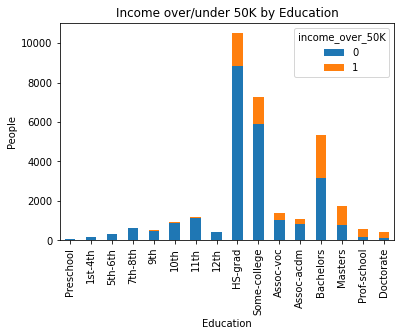

In [38]:
#Plot of education vs income, with raw counts. Sorted by lowest to highest education
df1 = df[['education.num','income_over_50K']].groupby(['education.num', 'income_over_50K']).size().unstack()
df1 = df1.sort_index()
df1.index = df1.index.map(education_dict)
df1.plot(kind='bar', stacked=True)
plt.xlabel('Education')
plt.ylabel('People')
plt.title('Income over/under 50K by Education')

In [17]:
# try random forest model. Looking for predictive power and get feature importances
dummy_df = pd.get_dummies(df.drop('education', axis=1)) #need to dummify object columns for random forest to work. Dropping education because it's redundant with education.num
X = dummy_df.drop('income_over_50K', axis=1)
y = dummy_df['income_over_50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
rf.score(X_test,y_test)

0.8188163037409268

In [20]:
# Print the feature ranking
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(min(X.shape[1],20)):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature age (0.276803)
2. feature education.num (0.154152)
3. feature hours.per.week (0.135545)
4. feature marital.status_Married-civ-spouse (0.072537)
5. feature relationship_Husband (0.049222)
6. feature occupation_Exec-managerial (0.023039)
7. feature marital.status_Never-married (0.020708)
8. feature occupation_Prof-specialty (0.020001)
9. feature sex_male (0.017956)
10. feature relationship_Own-child (0.014019)
11. feature relationship_Wife (0.013327)
12. feature relationship_Not-in-family (0.012184)
13. feature workclass_Private (0.011814)
14. feature occupation_Other-service (0.010067)
15. feature workclass_Self-emp-not-inc (0.009500)
16. feature occupation_Craft-repair (0.008205)
17. feature marital.status_Divorced (0.008093)
18. feature occupation_Sales (0.007924)
19. feature race_White (0.007918)
20. feature native.country_United-States (0.007780)


([<matplotlib.axis.XTick at 0x7fa331f4e350>,
 [Text(0, 0, '0'),
  Text(20, 0, '20'),
  Text(40, 0, '40'),
  Text(60, 0, '60'),
  Text(80, 0, '80')])

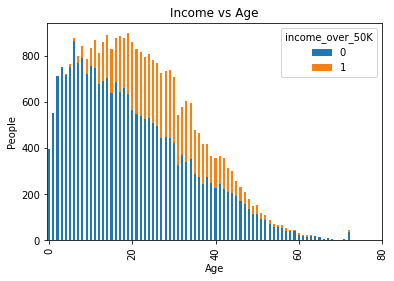

In [51]:
#Plot of age vs income, with raw counts. Sorted by lowest to highest age
df1 = df[['age','income_over_50K']].groupby(['age', 'income_over_50K']).size().unstack()
df1 = df1.sort_index()
df1.index = df1.index.map(education_dict)
df1.plot(kind='bar', stacked=True)
plt.xlabel('Age')
plt.ylabel('People')
plt.title('Income vs Age')
plt.xticks(np.arange(0, 100, step=20), np.arange(0, 100, step=20))

([<matplotlib.axis.XTick at 0x7fa3321bb1d0>,
 [Text(0, 0, '0'),
  Text(20, 0, '20'),
  Text(40, 0, '40'),
  Text(60, 0, '60'),
  Text(80, 0, '80')])

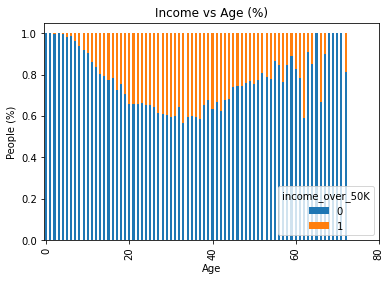

In [52]:
df1_1 = df1.div(df1.sum(1), axis=0)
df1_1.plot(kind='bar', stacked=True)
plt.xlabel('Age')
plt.ylabel('People (%)')
plt.title('Income vs Age (%)')
plt.xticks(np.arange(0, 100, step=20), np.arange(0, 100, step=20))

Text(0.5, 1.0, 'Income vs Education')

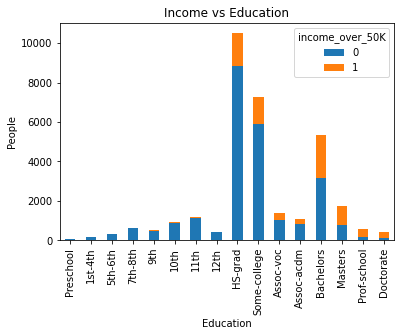

In [53]:
#Plot of age vs income, with raw counts. Sorted by lowest to highest age
df2 = df[['education.num','income_over_50K']].groupby(['education.num', 'income_over_50K']).size().unstack()
df2 = df2.sort_index()
df2.index = df2.index.map(education_dict)
df2.plot(kind='bar', stacked=True, title='Income over/under 50K by education')
plt.xlabel('Education')
plt.ylabel('People')
plt.title('Income vs Education')

Text(0.5, 1.0, 'Income vs Education (%)')

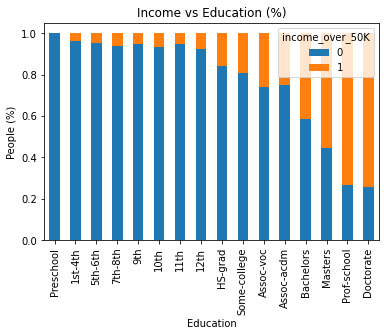

In [54]:
df2_1 = df2.div(df2.sum(1), axis=0)
df2_1.plot(kind='bar', stacked=True)
plt.xlabel('Education')
plt.ylabel('People (%)')
plt.title('Income vs Education (%)')